# Contour features

[Shape description (pdf version)](../../pdf/shape_description.pdf)

## chain code algorithm
Chain code algorithm is a method that describes the contour of a connected set as an ordered set of pixels (see below).

<img src="../../data/chain.png">

The algorithm starts from an arbitrary pixel of the contour, e.g. found by rasterazing the image, the first object point detected being used.

at each iteration on try to find the next border pixel, the order of test is givenby the arrows in the upper right corner, starting from the direction just after the direction of arrival, i.e. the first direction(3) correspond to the first detected object pixel starting from (1) because (1) is the first direction after (0) which is the direction of 'arrival' of the raster. The new search position is given by :

$$mod_7 (n+5)$$

so here the next search direction is

$$mod_7 (3+5) = 1$$

for the second step, the found direction is (2), the next search direction is 

$$mod_7 (2+5) = 0$$

the process is iterated until the first pixel is reached again.

Polygon area and centroid can be computed from the chain code, if $(x_i,y_i)$ if the sequence of object contour,

for a chain of $n$ pixels, the area is 

$$Area = \frac{\sum_{i=0}^{n-1}(x_i+x_{mod_n(i+1)})(y_1-y_{mod_n(i-1)})}{2} $$

and centroïd is

$$g_x = \frac{\sum_{i=0}^{n-1}(x_i+x_{mod_n(i+1)})^2(y_1-y_{mod_n(i-1)})^2}{Area} $$

$$g_y = \frac{\sum_{i=0}^{n-1}(y_i+y_{mod_n(i+1)})^2(x_1-x_{mod_n(i-1)})^2}{Area} $$




>see also:
* Chain coding **[DIP]** p484


## polygonal approximation

<img src="../../data/polygon.png">

## 2D shape descriptors (contours)

### Form factor

$$Formfactor = \frac {4 \pi Area}{Perimeter} $$

### Convexity

$$Convexity = \frac {Convex Perimeter}{Perimeter} $$

$$Solidity = \frac {Area}{Convex Area} $$

### Moments
One define moments such as ($f$ is considered here as a constant e.g. $1$)

$$ m_{pq} = \sum_{p= -\infty}^{+\infty}\sum_{q=-\infty}^{+\infty} x^p \; y^q \; f(x,y) $$

moments are centralized with respect to the object centroïd

$$ \mu_{pq} = \sum_{p= -\infty}^{+\infty}\sum_{q=-\infty}^{+\infty} (x-\bar x)^p \; (y-\bar y)^q \; f(x,y) $$ 



principal direction is given by

$$\theta = \tan^{-1} \big(\frac{2\;\mu_{11}}{\mu_{20}-\mu_{02}}\big)$$



$$
M = 
\begin{bmatrix}
    \mu_{20}       & \mu_{11} \\
    \mu_{11}       & \mu_{02} \\
\end{bmatrix}
$$

eigen values of $M$ are

$$
\lambda_i = \frac{\mu_{20} + \mu_{02}}{2}  \pm \frac{\sqrt{4{\mu}_{11}^2 + ({\mu}_{20}-{\mu}_{02})^2  }}{2}
$$

**Eccentricity** is given by

$$\sqrt{1 - \frac{\lambda_2}{\lambda_1}}$$

### Aspect ratio

The aspect ratio is given by the ratio between major and minor axes. The major axis is length of the major axis of the ellipse that has the same normalized second central moments as the shape, similarily, the minor axis is the length of the ellipse mino axis.

$$Aspect Ratio = \frac {Max\: diameter}{Min\: diameter} $$

The equivallent diameter is the diameter of the disk having the same area.

$$Eq.dia. =  \sqrt { \frac 4 \pi Area} $$

>see also:
* 2D shape descriptors (contours) **[DIP]** p.499 , **[IPH]** p.490


## Fourier contour description

Contour can be seen as a 1D periodic function, e.g. by taking the distance to the centroïd as a function of an angle (see below).
The circle has obviously a constant radius whereas the square presents a variable distance...

<img src="../../data/unwrapped.png">

Still, there is a problem when $r(\theta)$ is not a function, as illustrated below, for a same $\theta$, there is two different $r(\theta)$.

<img src="../../data/unwrap2.png">

One solution, is to use the curvilinear coordinate along the contour and to express the radius with respect to that coordinate.

In the example below, one use the distance to the centroid of each contour pixel (chain) as a 1D contour description.

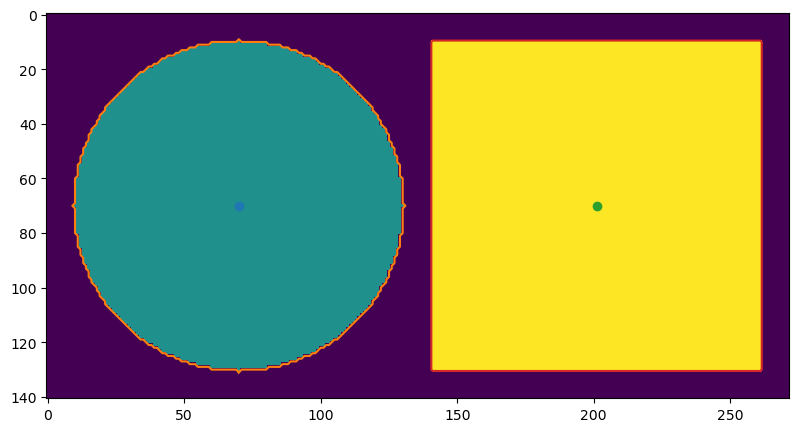

In [1]:
import numpy as np
from skimage.morphology import disk, square
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, find_contours

radius = 60
side = 2*radius+1
im = np.zeros((side+20,2*side+30))
im[10:10+side,10:10+side] = disk(radius)
im[10:10+side,side+20:side+20+side] = square(side)

lab = label(im)
props = regionprops(lab)

plt.figure(figsize=[10,5])
plt.imshow(lab,interpolation='nearest')

for obj in props:
    perim = find_contours(lab,obj.label-1)[0]
    plt.plot(obj.centroid[1],obj.centroid[0],'o')
    plt.plot(perim[:,1],perim[:,0])
plt.show();

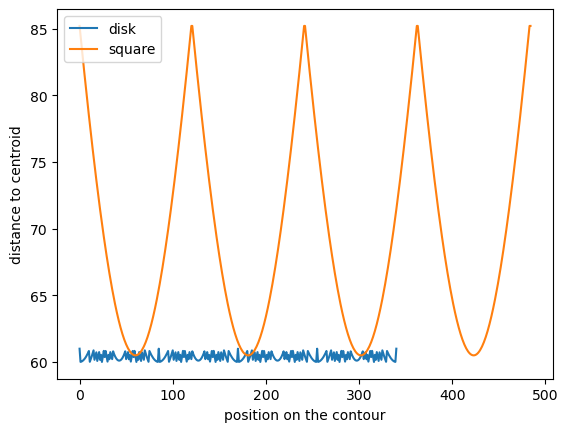

In [2]:
labels = ['disk','square']
for i,obj in enumerate(props):
    perim = find_contours(lab,obj.label-1)[0]
    xy = perim - obj.centroid
    r = np.sqrt(xy[:,0]**2+xy[:,1]**2)    
    plt.plot(r,label=labels[i])
#plt.gca().set_ylim([0,15])
plt.xlabel('position on the contour')    
plt.ylabel('distance to centroid')    
plt.legend(loc=0);
plt.show()

In the example above, the disk exhibits an irregular profile due to its discrete representation.

The 1D signalm obtained are periodic by definition. Let's compute a Fourier transform on them.

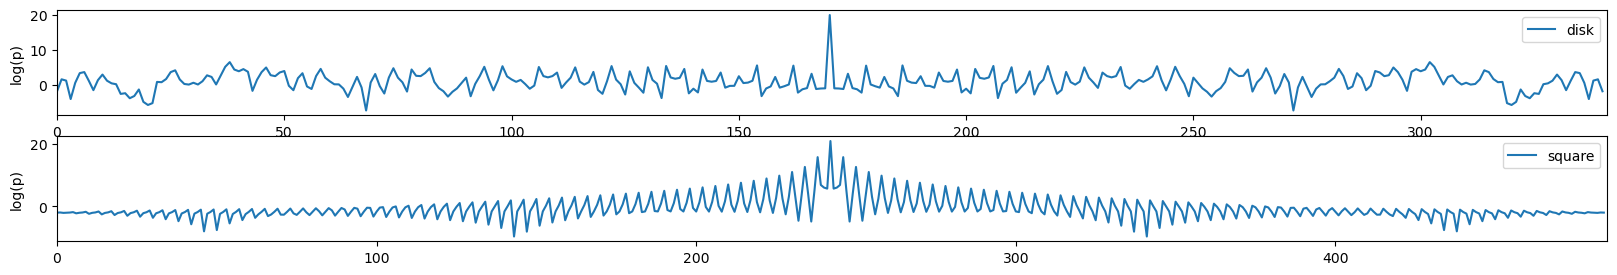

In [3]:
from numpy.fft import fft, fftshift
plt.figure(figsize=[20,3])
for i,obj in enumerate(props):
    perim = find_contours(lab,obj.label-1)[0]
    xy = perim - obj.centroid
    r = np.sqrt(xy[:,0]**2+xy[:,1]**2)    
    R = fft(r)
    
    p = np.abs(fftshift(R))**2
    log_p = np.nan_to_num(np.log(p))
    plt.subplot(2,1,i+1)
    plt.plot(log_p,label=labels[i])
    plt.ylabel('log(p)')
    plt.legend(loc=0);
    #plt.gca().set_ylim([0,1000])
    plt.gca().set_xlim([0,r.shape[0]])

plt.show()

We see that the Fourier power spectrum of the circle is almost in the continuous part (zero frequency is centered). On the contrary, the square exhibits an important contribution at a frequency corresponding to the oscillations.

## Fractal analysis

The measure of a length is related to the scale used. If the scale is small, the details measured are more numerous and the overall length is higher. In many situations the dependency between scale $\lambda_i$ and total length $L_2$ the following equation is verified (with a constant $f$) :

$$ \log L_2(X,\lambda_i) = f \; \log \lambda_i $$




> see also:
>
> Minkowski fractal dimension  
>
> see also The image processing handbook,Russ, John C. 2006. CRC press, p442
